# Natural Language Processing 
### CS-UH 2216 - Spring 2019
## Sentiment Analysis of 100,000 IMDB movie reviews
---


## Downloading the Imdb movie review data set

In [1]:
import warnings
warnings.filterwarnings('ignore') 

import os

# The code below will check to see if the data directory exists; if not, it will download the data.
if os.path.exists("./aclImdb") == False:
    print("Downloading the Imdb movie review data set")
    !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar xf aclImdb_v1.tar.gz
#Shell command to show the files and directories we have under aclImdb
!ls aclImdb/*

aclImdb/imdbEr.txt  aclImdb/imdb.vocab	aclImdb/README

aclImdb/test:
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt

aclImdb/train:
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


# 1. Analysis of data

In [2]:
#Run this cell first
print("number of positive training examples:")
pos_train = !ls aclImdb/train/pos/ | wc -l
pos_train = int(pos_train[0])
print(pos_train)
print("number of negative training examples:")
neg_train = !ls aclImdb/train/neg/ | wc -l
neg_train = int(neg_train[0])
print(neg_train)
print("number of unlabelled training examples:")
unl_train = !ls aclImdb/train/unsup/ | wc -l
unl_train = int(unl_train[0])
print(unl_train)
print("number of positive testing examples:")
pos_test = !ls aclImdb/test/pos/ | wc -l
pos_test = int(pos_test[0])
print(pos_test)
print("number of negative testing examples:")
neg_test = !ls aclImdb/test/pos/ | wc -l
neg_test = int(neg_test[0])
print(neg_test)

number of positive training examples:
12500
number of negative training examples:
12500
number of unlabelled training examples:
50000
number of positive testing examples:
12500
number of negative testing examples:
12500


#### 1.1 How many reviews are for training? 75000

In [3]:
print("total number of training reviews:" )
print(pos_train + neg_train + unl_train)

total number of training reviews:
75000


#### 1.2 How many reviews are for testing? 25000

In [4]:
print("total number of training reviews:" )
print(pos_test + neg_test)

total number of training reviews:
25000


#### 1.3 How many reviews are positive (in total in training and testing)? 25000

In [5]:
print("total positive instances in training and testing" )
print(pos_train + pos_test)

total positive instances in training and testing
25000


#### 1.4 How many reviews are negative (in total in training and testing)? 25000

In [6]:
print("total negative instances in training and testing" )
print(neg_train + neg_test)

total negative instances in training and testing
25000


#### 1.5 How many reviews are unlabelled (in total in training and testing)? 50000

In [7]:
print("total negative instances in training and testing" )
print(unl_train)

total negative instances in training and testing
50000


#### 1.6 What can we use unlabeled reviews for? 

We can use the unlabeled reviews for building unsupervised learning classification algorithms that can cluster and learn labels of reviews without being given the rating

#### 1.7 How was the positive/negative labeling done?

The positive and negative labels are classified based on the rating of the user reviews. A negative class is given to ratings <= 4 and a positive class is given to ratings >= 7 out of 10. Hence, reviews with more neural ratings are not included in the positive/negative sets

#### 1.8 Simply based on the labeling approach, do we expect some reviews to be harder than others for sentiment analysis?

Yes. This is because some reviews with the same label(pos/neg class) are closer to the extreme ends of the scale (1 ratings) while other reviews are closer to the neural end (4 rating). We would expect reviews with the same label but closer to the extreme end of the scale, to be easier to analyze because they likely have more obvious features which we can use for classification

#### 1.9 How many are the most negative review [1] (train and test)?

In [8]:
max_neg_test = !ls aclImdb/test/neg/ | grep "\w*1.txt" | wc -l
max_neg_test = int(max_neg_test[0])
max_neg_train = !ls aclImdb/train/neg/ | grep "\w*1.txt" | wc -l
max_neg_train = int(max_neg_train[0])
print("Total number of most negative reviews")
print(max_neg_test + max_neg_train)

Total number of most negative reviews
10122


#### 1.10 How many are the most positive reviews [10] (train and test)?

In [9]:
max_pos_test = !ls aclImdb/test/pos/ | grep "\w*10.txt" | wc -l
max_pos_test = int(max_pos_test[0])
max_pos_train = !ls aclImdb/train/pos/ | grep "\w*10.txt" | wc -l
max_pos_train = int(max_pos_train[0])
print("Total number of most positive reviews")
print(max_pos_test + max_pos_train)

Total number of most positive reviews
9731


## Load data to memory

In [10]:
import sklearn
from sklearn.datasets import load_files #load_files load text files with categories as subfolder names; 

# Directory of our data
traindir = r'./aclImdb/train'
testdir = r'./aclImdb/test'

# load pos/neg train and test data
train=load_files(traindir,categories=['pos','neg']) #load_files shuffles the text and categories by default.
test=load_files(testdir,categories=['pos','neg'])

# load an object with all the training data (positive, negative and unlabeled)
alltrain = load_files(traindir,categories=['pos','neg','unsup'])
#load_files return a dictionary-like object:
#1. 'data': the raw text data to learn
#2. 'target': the classification labels (integer index)
#3. 'target_names': the meaning of the labels
#4. 'filenames': the name of the file holding the data point

In [11]:
#Browse an example
#For example, if we want to see data point with index i 
i = 13374
print("Index  = %3d\n" % (i))
print("Text = %s\n" % (train.data[i]))
print("Label = %s\n" %(train.target_names[train.target[i]]))
print("Filename = %s\n" % (train.filenames[i]))

Index  = 13374

Text = b'Since this movie was based on a true story of a woman who had two children and was not very well-off, it was just scary as to how real it really was! The acting is what gave the movie that push to greatness.<br /><br />Diane Keaton portrayed the main character, Patsy McCartle who had two sons whom she adored. Her performance is what made the real life story come to life on a television screen. It was very hard to watch some of the scenes since they were so real as to what happens when one becomes addicted to drugs.<br /><br />Just watching this very loving mother go from sweet to not caring at all was hard, but so true. I have known people who have gone through withdrawl and it was very much like what happened in this movie, from what I remember.<br /><br />I also thought that it was very risky for the director to want to make a movie out of what happened to this woman. Yet it was done so well. I applaud the director for making this movie.<br /><br />I highly r

# 2. Investigating the quality of data

In [12]:
#Function to determine rating given the review filename
import re
def getRating(filename):
    match = re.search("_(.+).txt",filename)
    if match: #If we have found something
        return(int(match.group(1))) #Return the first capture group ()
    else:
        return None

In [13]:
def find_and_print_rating(rating):
    #listing filename, label, and at least the first 10 words of text
    for i in range(len(train.filenames)):
        if(getRating(train.filenames[i]) == rating):
            print("Label = %s" %(train.target_names[train.target[i]]))
            print("Filename: ", train.filenames[i])
            print("Rating: ", getRating(train.filenames[i]))
            print("Text: ", train.data[i][0:200])
            break

#### 2.1 Identify an example of a strong negative sentiment based on human ratings

In [14]:
find_and_print_rating(1)

Label = neg
Filename:  ./aclImdb/train/neg/6802_1.txt
Rating:  1
Text:  b"Words can't describe how bad this movie is. I can't explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do th"


#### 2.2 Identify an example of a weak negative sentiment based on human ratings

In [15]:
find_and_print_rating(4)

Label = neg
Filename:  ./aclImdb/train/neg/9503_4.txt
Rating:  4
Text:  b'Also known in a different form as "House of Exorcism," this messy<br /><br />little film takes itself so seriously as to kill any entertainment value<br /><br />whatsoever.<br /><br />The spare plot i'


#### 2.3 Identify an example of a strong positive sentiment based on human ratings

In [16]:
find_and_print_rating(10)

Label = pos
Filename:  ./aclImdb/train/pos/11485_10.txt
Rating:  10
Text:  b'Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of be'


#### 2.4 Identify an example of a weak positive sentiment based on human ratings 

In [17]:
find_and_print_rating(7)

Label = pos
Filename:  ./aclImdb/train/pos/9846_7.txt
Rating:  7
Text:  b'Ok, at the beginning it looked like "Shrek" - the loner that is persistently followed by the comic relief. Then it evolves into something really compelling, as the gauntlet is set. And the result is a'


#### 2.5 List one observation of a feature of the text that you think will be helpful to predict sentiment.

It seems that the choice of vocabulary seems to be correlated with the rating of the review. Certain vocabulary such as "Horrible" are seen significantly more frequently in negative instances than in positive instances

In [18]:
#Number of reviews with "Horrible" in contents.
negativeOccurances = 0
positiveOccurances = 0
for i in range(len(train.filenames)):
    if(train.target_names[train.target[i]] == 'pos'):
        if 'horrible' in str(train.data[i]):
            positiveOccurances += 1
    else:
        if 'horrible' in str(train.data[i]):
            negativeOccurances += 1
print("Number of times \"horrible\" appeared in negative reviews: ", negativeOccurances)
print("Number of times \"horrible\" appeared in positive reviews: ", positiveOccurances)

Number of times "horrible" appeared in negative reviews:  796
Number of times "horrible" appeared in positive reviews:  150


# 3. Building a basic sentiment analyzer

Vectorize our text data

In [19]:
from sklearn.feature_extraction.text import CountVectorizer #Vectorize our text with top 1000 frequent vocabulary

In [20]:
#Create the vectorizer and transform our data
vectorizer = CountVectorizer(max_features=1000,analyzer='word',lowercase=True) #Tokenize at word level
vectorizer.fit(alltrain.data)
train_data_vectorized = vectorizer.transform(train.data)

Implement a logistic linear regression model

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
model.fit(train_data_vectorized, train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Predict with the model

In [22]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
test_pred = model.predict(vectorizer.transform(test.data))
#Preliminary evaluation with sklearn
print ("Accuracy  = %3.2f%%" % (100*accuracy_score(test.target, test_pred)))
print ("Average Precision = %3.2f%%" % (100*precision_score(test.target, test_pred, average='macro')))
print ("Average Recall    = %3.2f%%" % (100*recall_score(test.target, test_pred, average='macro')))
print ("Average F1-score  = %3.2f%%" % (100*f1_score(test.target, test_pred, average='macro')))
# The scores for accuracy, and average precision, recall and F1-score are similar. 
# This is in part an effect of the balanced nature of the data.

Accuracy  = 85.96%
Average Precision = 85.97%
Average Recall    = 85.96%
Average F1-score  = 85.95%


### 3.1 Evaluating Accuracy, Recall and F1 scores without sklearn

In [23]:
#Record the instances of correct and incorrect predictions
num_neg = 0
num_pos = 0
neg_correct = 0
neg_incorrect = 0
pos_correct = 0
pos_incorrect = 0

for i in range(len(test.target)):
    if test.target[i] == 0:
        num_neg +=1
        if test_pred[i] == 0:
            neg_correct += 1
        elif test_pred[i] == 1:
            neg_incorrect += 1
    elif test.target[i] == 1:
        num_pos += 1
        if test_pred[i] == 0:
            pos_incorrect += 1
        elif test_pred[i] == 1:
            pos_correct += 1

print("Total instances %d" % (num_neg + num_pos))
print("Total correct predictions %d" % (pos_correct + neg_correct) )
print("Correctly predicted negative %d" % (neg_correct))
print("Incorrectly predicted negative %d" % (neg_incorrect))
print("Correctly predicted positive %d" % (pos_correct))
print("Incorrectly predicted positive %d" % (pos_incorrect))

Total instances 25000
Total correct predictions 21489
Correctly predicted negative 10617
Incorrectly predicted negative 1883
Correctly predicted positive 10872
Incorrectly predicted positive 1628


In [24]:
#Accuracy = Correctly predicted / Total
Accuracy = (pos_correct + neg_correct)/(num_neg + num_pos)
print("Accuracy: %2.2f%%" % (100*Accuracy))
print()

#Neg label precision = neg_correct / (neg_correct + pos_incorrect)
neg_precision = neg_correct / (neg_correct + pos_incorrect)
print("Neg label precision: %2.2f%%" % (100*neg_precision))

#Recall of Neg = neg_correct / num_neg
neg_recall = neg_correct / num_neg
print("Neg label recall: %2.2f%%" % (100*neg_recall))

#F1-score harmonic mean of precision and recall. = 
neg_f1 = 1/( ((1/neg_precision)+(1/neg_recall))/2 )
print("Neg F1 score: %2.2f%%" % (100*neg_f1))
print()

#Pos label precision = pos_correct / (pos_correct + neg_incorrect)
pos_precision = pos_correct / (pos_correct + neg_incorrect)
print("Pos label precision: %2.2f%%" % (100*pos_precision))

#Recall of Pos = pos_correct / num_pos
pos_recall = pos_correct / num_pos
print("Pos label recall: %2.2f%%" % (100*pos_recall))

#F1-score harmonic mean of precision and recall. = 
pos_f1 = 1/( ((1/pos_precision)+(1/pos_recall))/2 )
print("Pos F1 score: %2.2f%%" % (100*pos_f1))
print()

print("Average precision %2.2f" % (100*(neg_precision + pos_precision)/2))
print("Average recall %2.2f" % (100*(neg_recall + pos_recall)/2))
print("Average F1 score %2.2f%%" % (100*(neg_f1 + pos_f1)/2))

Accuracy: 85.96%

Neg label precision: 86.70%
Neg label recall: 84.94%
Neg F1 score: 85.81%

Pos label precision: 85.24%
Pos label recall: 86.98%
Pos F1 score: 86.10%

Average precision 85.97
Average recall 85.96
Average F1 score 85.95%


# 4. Individual accuracies

### 4.1 Accuracy for each rating (1-4, 7-10)

In [25]:
ratingCorrect = dict()
ratingIncorrect = dict()
ratings = [1,2,3,4,7,8,9,10]
#Initialize the ratings
for rating in ratings:
    ratingCorrect[rating] = 0
    ratingIncorrect[rating] = 0
    
#Count correct and incorrect instances
for i in range(len(test.target)):
    rating = getRating(test.filenames[i])
    if test.target[i] == test_pred[i]:
        ratingCorrect[rating] += 1
    else:
        ratingIncorrect[rating] += 1

# Print the accuracy.
for rating in ratings:
    print("Rating %d accuracy: %2.2f" % (rating, 100*ratingCorrect[rating]/(ratingCorrect[rating]+ratingIncorrect[rating])))
    if rating == 4:
        print() #Print a space betwen "positive" and "negative" ratings

Rating 1 accuracy: 91.48
Rating 2 accuracy: 87.62
Rating 3 accuracy: 81.74
Rating 4 accuracy: 73.21

Rating 7 accuracy: 79.11
Rating 8 accuracy: 85.40
Rating 9 accuracy: 89.46
Rating 10 accuracy: 90.34


We observe that our performance increases near the extreme for the negative class (1) and the extreme for the positive class (10). The performance decreases when the ratings are more neural and close to the center of the scale. This was predicted earlier in § 1.8

### 4.2 Data samples for each instance in the cofusion matrix (TP FP FN TN)

Let's analyze instances of TN(Neg Neg) FP (Neg Pos) FN(Pos Neg) and TP (Pos Pos)

In [26]:
def getInstance(gold, pred):
    for i in range(len(test.target)):
        if test.target[i] == gold and test_pred[i] == pred:
            return(i)
    return(-1)

In [27]:
print("True negative")
instance = getInstance(0,0)
print("Gold: Neg | Predicted: Neg | Match: Correct | Rating: ", getRating(test.filenames[instance]))
print("Text:")
print(test.data[instance])
print()

True negative
Gold: Neg | Predicted: Neg | Match: Correct | Rating:  1
Text:
b'I don\'t know how this movie has received so many positive comments. One can call it "artistic" and "beautifully filmed", but those things don\'t make up for the empty plot that was filled with sexual innuendos. I wish I had not wasted my time to watch this movie. Rather than being biographical, it was a poor excuse for promoting strange and lewd behavior. It was just another Hollywood attempt to convince us that that kind of life is normal and OK. From the very beginning I asked my self what was the point of this movie,and I continued watching, hoping that it would change and was quite disappointed that it continued in the same vein. I am so glad I did not spend the money to see this in a theater!'



This negative example was correctly predicted negatively. Since we are analyzing word frequency, this review has a lot of words such as "dissapointed" "poor" "attempt" and "wasted" which would have likely pushed the algorithm to predict a negative classification

In [28]:
print("False positive")
instance = getInstance(0,1)
print("Gold: Neg | Predicted: Pos | Match: Incorrect | Rating: ", getRating(test.filenames[instance]))
print("Text:")
print(test.data[instance])
print()

False positive
Gold: Neg | Predicted: Pos | Match: Incorrect | Rating:  4
Text:
b"Even Disney are guilty of the cash cow disease, after the roaring success of The Love Bug in 1968, the house of mouse cashed in with Herbie Rides Again, Herbie Goes To Monte Carlo, and Herbie Goes Bananas. Neither sequel capturing the charm and inoffensive appeal of The Love Bug back in 68, in this one we find race driver Jim Douglas and his sidekick Wheely Applegate, entering Herbie in the Monte Carlo Rally. Naturally things outside of the race start to take over priorities, they get mixed up in a diamond robbery and Herbie falls in love with another car!. The car stunts are of course pleasant and easy on the eye, and it would be churlish of me to really vent venom on such a friendly piece of fluff, it's just that the film goes nowhere fast and personally now i can see it for the coin motivated piece of work it is. Still you get to see Herbie take a bath, foil the baddies and of course dance for the lady

This example was predicted to be positive when it was negative. First this example was a difficult review to classify as it's rating was quite near the center (4). Second, the review uses a lot of vocabulary such as "love" "pleasant" "charm" frequently which indicate that the reviewed liked the movie. The model doesn't know that the reviewer could be describing the contents of the movie

In [29]:
print("False negative")
instance = getInstance(1,0)
print("Gold: Pos | Predicted: Neg | Match: Incorrect | Rating: ", getRating(test.filenames[instance]))
print("Text:")
print(test.data[instance])
print()

False negative
Gold: Pos | Predicted: Neg | Match: Incorrect | Rating:  7
Text:
b"The casting of Robert Culp is probably the only decent move the production team made with this film. Falk and Culp were marvellous, but as culp was not Falks nemesis this time, chemistry was lacking. Columbo is only as strong as his opposite number, and this time he didn't have one."



Similar to the above review, this review was also close to the center of the scale. In addition, even as a human reading the review, it would be difficult to predict the correct rating. The words used in this review doesn't indicate clearly that it is positive.

In [30]:
print("True positive")
instance = getInstance(1,1)
print("Gold: Pos | Predicted: Pos | Match: Correct | Rating: ", getRating(test.filenames[instance]))
print("Text:")
print(test.data[instance])

True positive
Gold: Pos | Predicted: Pos | Match: Correct | Rating:  9
Text:
b"Don't hate Heather Graham because she's beautiful, hate her because she's fun to watch in this movie. Like the hip clothing and funky surroundings, the actors in this flick work well together. Casey Affleck is hysterical and Heather Graham literally lights up the screen. The minor characters - Goran Visnjic {sigh} and Patricia Velazquez are as TALENTED as they are gorgeous. Congratulations Miramax & Director Lisa Krueger!"


This review was correctly predicted positive. It's likely because of the positive words used "fun", "work well" and "congratulations"

# 5. Investigating the effect of training size on accuracy

We increment the training size from 1000 to 25000 in increments of 1000 and examine the increase in accuracy as we increase the training size

In [35]:
#Create the vectorizer
vectorizer = CountVectorizer(max_features=1000,analyzer='word',lowercase=True) #Tokenize at word level
vectorizer.fit(alltrain.data) #We use all the data for training the vectorization strategy as this is not part of the ML model.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [42]:
#Train the model with varying sizes of train data
F1list = [] #Track the F1 scores
trainSize = [] #Track our training size
for i in range(1,26):
    trainSize.append(i*1000)
    #Create a model
    model = LogisticRegression(solver='liblinear')
    #Train with our dataset
    model.fit(vectorizer.transform(train.data[0:i*1000]), train.target[0:i*1000])
    #Vectorize our test data.
    test_pred = model.predict(vectorizer.transform(test.data))
    #Determine our F1 score
    F1 = 100*f1_score(test.target, test_pred, average='macro')
    print ("Training size: %d Average F1-score: %3.2f%%" % (i*1000, F1))
    F1list.append(F1)

Training size: 1000 Average F1-score: 77.57%
Training size: 2000 Average F1-score: 79.22%
Training size: 3000 Average F1-score: 79.96%
Training size: 4000 Average F1-score: 80.56%
Training size: 5000 Average F1-score: 81.76%
Training size: 6000 Average F1-score: 82.57%
Training size: 7000 Average F1-score: 82.83%
Training size: 8000 Average F1-score: 83.71%
Training size: 9000 Average F1-score: 84.24%
Training size: 10000 Average F1-score: 84.52%
Training size: 11000 Average F1-score: 84.58%
Training size: 12000 Average F1-score: 84.76%
Training size: 13000 Average F1-score: 84.97%
Training size: 14000 Average F1-score: 85.18%
Training size: 15000 Average F1-score: 85.33%
Training size: 16000 Average F1-score: 85.59%
Training size: 17000 Average F1-score: 85.51%
Training size: 18000 Average F1-score: 85.68%
Training size: 19000 Average F1-score: 85.70%
Training size: 20000 Average F1-score: 85.72%
Training size: 21000 Average F1-score: 85.82%
Training size: 22000 Average F1-score: 85.9

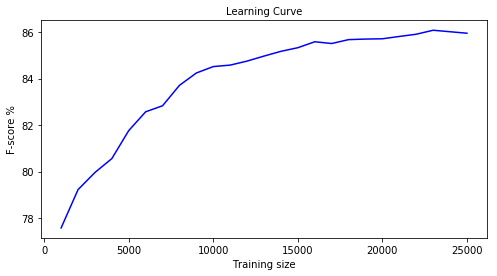

In [41]:
#Plot our F1 against data Size
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4)) 
plt.plot(trainSize,F1list,color='blue')
plt.xlabel('Training size', fontsize=10)
plt.ylabel('F-score %', fontsize=10)
plt.title('Learning Curve',fontsize=10)
plt.show()

I observe that our logistic regression model was suprisingly accurate even when training even with a minimal of 1000 samples. It seems that given only 1000 samples, our model could identify the sentiment relatively well

I observe that as the training size increases, the F1 score of the model increases. For example, with only 1000 training samples we can achieve an accuracy of 77.6% while with 5,000 training samples we can achieve an accuracy of 81.8%. This is to be expected because the more training examples we have, the better the predicting capability and generalization to the unseen test the model is.

I also observe that as the training size increases, the rate of gain in F1 of adding on an additional 1000 sample decreased. Simply put the F1 score did not increase linearlly to the size of the Training. There appears to be a log relationship.

Between 1000 and 2000 examples, the F score increased 1.65% Between 2000 and 4000 it increased 1.34%. Between 4000 and 8000 it increased 3.15%. Between 8000 and 16000 it increased 1.88%. 

Following this observed relationship, I would expect an increase of around 2% for every doubling in training size. Hence, I expect an increase of another 2% to 88% if we add another 25000 examples. (Although this is not guranteed)
